In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

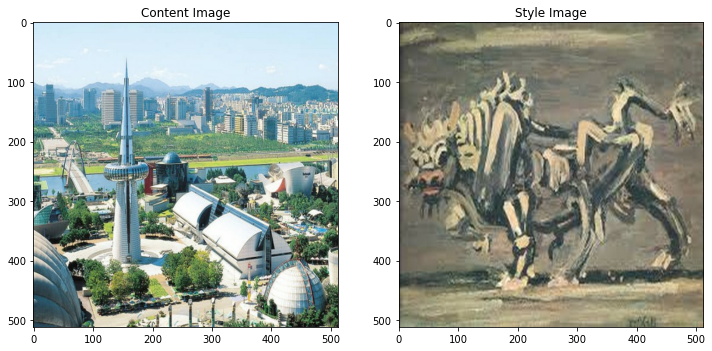

In [8]:
content_image = load_img('style_transfer/14/512/mm_0014.jpg')
style_image = load_img('style_transfer/14/512/0009.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

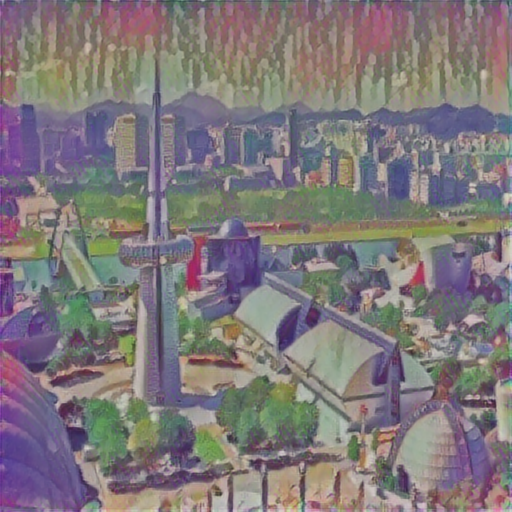

In [10]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [11]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 77s 0us/step


TensorShape([1, 1000])

In [12]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 1us/step


[('mosque', 0.40900603),
 ('dome', 0.19057715),
 ('planetarium', 0.086913235),
 ('greenhouse', 0.030531028),
 ('cannon', 0.028607829)]

In [13]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 8s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 512, 512, 64)
  최솟값:  0.0
  최댓값:  814.34814
  평균:  22.8468

block2_conv1
  크기:  (1, 256, 256, 128)
  최솟값:  0.0
  최댓값:  2446.4973
  평균:  127.51574

block3_conv1
  크기:  (1, 128, 128, 256)
  최솟값:  0.0
  최댓값:  6861.7676
  평균:  116.53072

block4_conv1
  크기:  (1, 64, 64, 512)
  최솟값:  0.0
  최댓값:  10346.008
  평균:  461.87338

block5_conv1
  크기:  (1, 32, 32, 512)
  최솟값:  0.0
  최댓값:  2547.7766
  평균:  34.792923



In [17]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [18]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.058828108
    최댓값:  60413.117
    평균:  743.7865

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  180930.47
    평균:  23876.48

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  606437.3
    평균:  22435.355

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  6469372.5
    평균:  287717.0

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  100188.484
    평균:  2391.5193

콘텐츠:
   block5_conv2
    크기:  (1, 32, 32, 512)
    최솟값:  0.0
    최댓값:  1441.8761
    평균:  18.494019


In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [21]:
image = tf.Variable(content_image)

In [22]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [24]:
style_weight=1e-2
content_weight=1e4

In [25]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [26]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

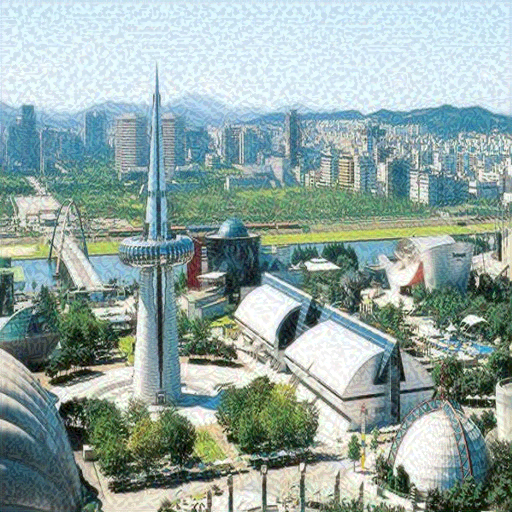

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

...................

In [27]:
file_name = './Neural_Style_Transfer/stylized-image_10epoch_train_15.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

In [28]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

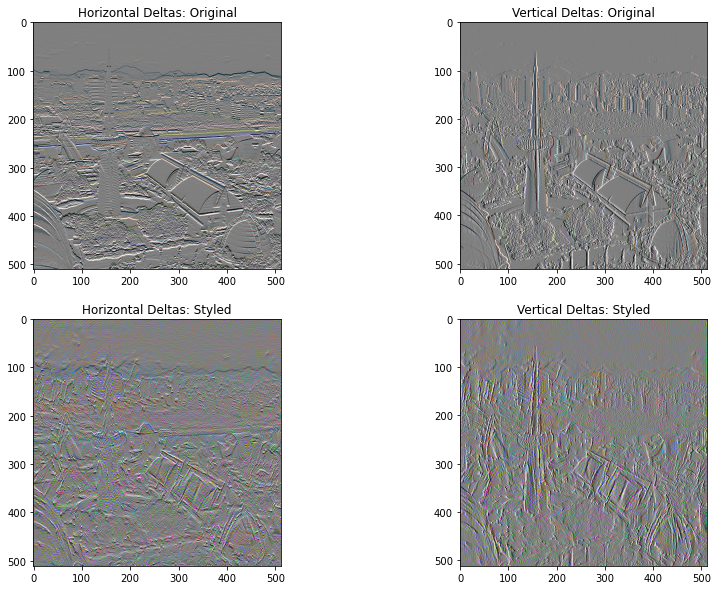

In [29]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

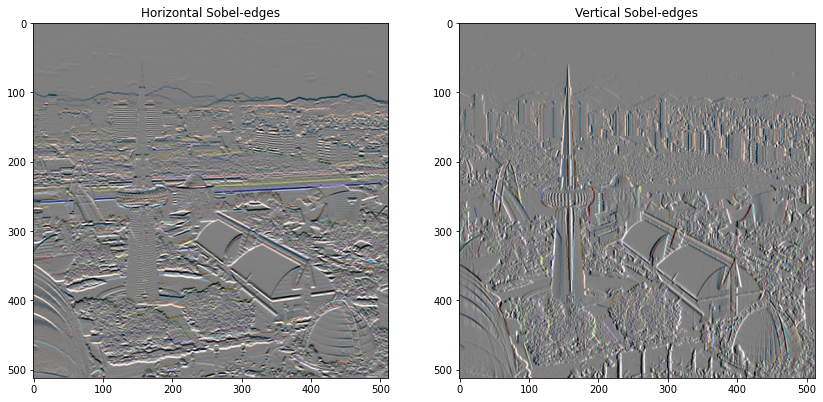

In [30]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [31]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(image).numpy()

139014.94

In [33]:
tf.image.total_variation(image).numpy()

array([139014.94], dtype=float32)

In [34]:
total_variation_weight=30

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [36]:
image = tf.Variable(content_image)

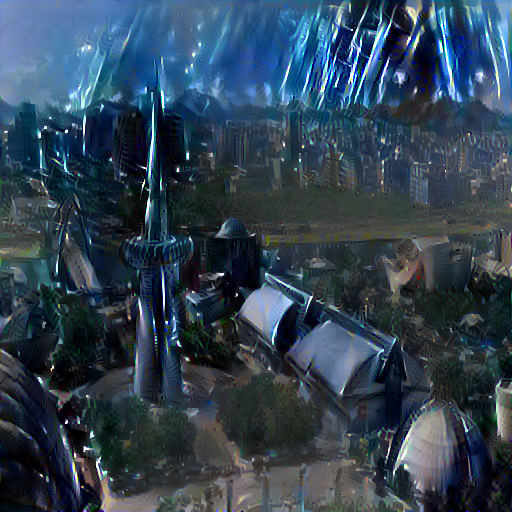

훈련 스텝: 4000
전체 소요 시간: 125.3


In [37]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 200

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

In [38]:
file_name = './Neural_Style_Transfer/stylized-image_15.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)